In [1]:
#from comet_ml import Experiment
import json
import wandb
import os
import yaml

In [2]:
import os

In [3]:
with open("/glock/gun/notebooks/api_key.txt", "r") as f:
    api_key = json.load(f)
    print("opened")
os.environ["WANDB_API_KEY"] = api_key["api_key"]

opened


In [4]:
from detectron2.data.datasets import register_coco_instances
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [5]:
register_coco_instances("weapons_test", {}, "/Pobrane/test_edge.json", "/Pobrane/edgetest_images")

In [6]:
register_coco_instances("weapons", {}, "/glock/20moreinstancesrescale/trainval.json", "/glock/20moreinstancesrescale")#register_coco_instances("weapons", {}, "/Pobrane/trainval.json", "/Pobrane/images")#

In [7]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [8]:
dataset_dicts = DatasetCatalog.get("weapons")
dataset_metadata = MetadataCatalog.get("weapons")
dataset_dicts_test = DatasetCatalog.get("weapons_test")
dataset_metadata_test = MetadataCatalog.get("weapons_test")

In [9]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/edgetest_images/inde0ks.jpeg


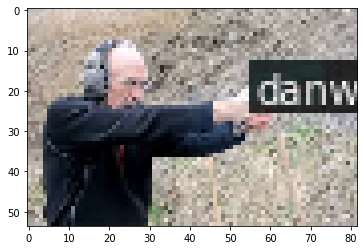

In [10]:
for d in random.sample(dataset_dicts_test, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata_test, scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

/glock/20moreinstancesscale/RGBcf8444fd-6b0b-49d6-8eb8-10b2f6210be7/rgb_2982.png


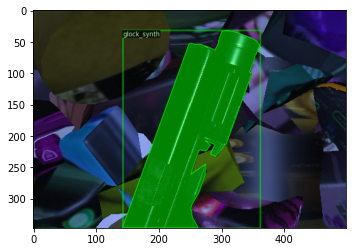

In [11]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [12]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [13]:
from datetime import datetime
import os

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 0

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.MODEL.RETINANET.NUM_CLASSES = 10

cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]

cfg.MODEL.BACKBONE.FREEZE_AT = 2
cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR =0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 40_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS =  5000
cfg.SOLVER.GAMMA = 0.8
cfg.SOLVER.STEPS = (10000, 20000, 30000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 1000
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [15]:
def cfg_node_to_dict(cfg):
    raw_cfg = yaml.safe_load(cfg.dump())
    return raw_cfg


In [16]:
#20_1.75to0.5,FREEZE_AT = 2

In [17]:
config = cfg_node_to_dict(cfg)
wandb.init(sync_tensorboard=True, project="weapons", name="20moreinstancesrescale_BATCH2_FREEZE_AT = 2", config=config, group="objectperframe")

wandb: Currently logged in as: miotk (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [18]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open("/glock/gun/config.yml", "w") as f:
    f.write(cfg.dump())

In [19]:
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [20]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
'''
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
'''
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True)#, augmentations=build_sem_seg_train_aug(cfg)
        return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
  
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/08 23:54:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/08 23:54:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/08 23:54:19 d2.data.datasets.coco]: Loaded 6887 images in COCO format from /glock/20moreinstancesscale/trainval.json
[12/08 23:54:19 d2.data.build]: Removed 941 images with no usable annotations. 5946 images left.
[12/08 23:54:20 d2.data.build]: Distribution of instances among all 10 categories:
|   category    | #instances   |  category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-------------:|:-------------|
| AK-74m_synth  | 4971         | colt_synth  | 3371         | danwesson_s.. | 1700         |
| enfield_synth | 1658         | glock_synth | 5101         |   m4_synth    | 4977         |
|   mp5_synth   | 1708         | scar_synth  | 1692         | thompson_sy.. | 1676         |
|  ab10_synth   | 1700

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (10, 256, 1, 

[12/08 23:54:20 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()


[12/08 23:54:35 d2.utils.events]:  eta: 7:44:39  iter: 19  total_loss: 3.364  loss_cls: 2.378  loss_box_reg: 0.203  loss_mask: 0.6924  loss_rpn_cls: 0.06428  loss_rpn_loc: 0.02205  time: 0.7031  data_time: 0.1914  lr: 4.7962e-06  max_mem: 4357M
[12/08 23:54:50 d2.utils.events]:  eta: 7:47:11  iter: 39  total_loss: 3.407  loss_cls: 2.235  loss_box_reg: 0.2021  loss_mask: 0.6921  loss_rpn_cls: 0.2022  loss_rpn_loc: 0.04577  time: 0.7053  data_time: 0.2094  lr: 8.7922e-06  max_mem: 4357M
[12/08 23:55:04 d2.utils.events]:  eta: 7:48:37  iter: 59  total_loss: 3.027  loss_cls: 1.95  loss_box_reg: 0.2158  loss_mask: 0.6909  loss_rpn_cls: 0.09491  loss_rpn_loc: 0.03824  time: 0.7038  data_time: 0.1985  lr: 1.2788e-05  max_mem: 4357M
[12/08 23:55:17 d2.utils.events]:  eta: 7:41:37  iter: 79  total_loss: 2.759  loss_cls: 1.572  loss_box_reg: 0.1939  loss_mask: 0.6892  loss_rpn_cls: 0.3027  loss_rpn_loc: 0.05722  time: 0.6929  data_time: 0.1984  lr: 1.6784e-05  max_mem: 4357M
[12/08 23:55:31 d2.u

[12/09 00:02:11 d2.utils.events]:  eta: 7:33:41  iter: 679  total_loss: 1.131  loss_cls: 0.3544  loss_box_reg: 0.2989  loss_mask: 0.3473  loss_rpn_cls: 0.1081  loss_rpn_loc: 0.04965  time: 0.6900  data_time: 0.1933  lr: 0.00013666  max_mem: 4573M
[12/09 00:02:24 d2.utils.events]:  eta: 7:32:51  iter: 699  total_loss: 1.13  loss_cls: 0.341  loss_box_reg: 0.2999  loss_mask: 0.2895  loss_rpn_cls: 0.07002  loss_rpn_loc: 0.04034  time: 0.6883  data_time: 0.1924  lr: 0.00014066  max_mem: 4573M
[12/09 00:02:36 d2.utils.events]:  eta: 7:31:48  iter: 719  total_loss: 1.038  loss_cls: 0.3481  loss_box_reg: 0.3047  loss_mask: 0.3057  loss_rpn_cls: 0.05692  loss_rpn_loc: 0.02972  time: 0.6863  data_time: 0.1900  lr: 0.00014466  max_mem: 4573M
[12/09 00:02:49 d2.utils.events]:  eta: 7:30:44  iter: 739  total_loss: 1.133  loss_cls: 0.3732  loss_box_reg: 0.3289  loss_mask: 0.2816  loss_rpn_cls: 0.0737  loss_rpn_loc: 0.03987  time: 0.6848  data_time: 0.1892  lr: 0.00014865  max_mem: 4573M
[12/09 00:03

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.03 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.03 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.1

[12/09 00:10:18 d2.utils.events]:  eta: 6:49:20  iter: 1439  total_loss: 0.8988  loss_cls: 0.2647  loss_box_reg: 0.1936  loss_mask: 0.2176  loss_rpn_cls: 0.06873  loss_rpn_loc: 0.03056  time: 0.6586  data_time: 0.1893  lr: 0.00028851  max_mem: 4934M
[12/09 00:10:30 d2.utils.events]:  eta: 6:48:25  iter: 1459  total_loss: 0.8911  loss_cls: 0.3316  loss_box_reg: 0.2394  loss_mask: 0.2131  loss_rpn_cls: 0.04891  loss_rpn_loc: 0.02955  time: 0.6582  data_time: 0.1892  lr: 0.00029251  max_mem: 4934M
[12/09 00:10:43 d2.utils.events]:  eta: 6:48:03  iter: 1479  total_loss: 0.8272  loss_cls: 0.3284  loss_box_reg: 0.2149  loss_mask: 0.1892  loss_rpn_cls: 0.03035  loss_rpn_loc: 0.02379  time: 0.6581  data_time: 0.1894  lr: 0.0002965  max_mem: 4934M
[12/09 00:10:56 d2.utils.events]:  eta: 6:47:34  iter: 1499  total_loss: 0.8633  loss_cls: 0.3187  loss_box_reg: 0.2052  loss_mask: 0.1919  loss_rpn_cls: 0.0326  loss_rpn_loc: 0.02527  time: 0.6581  data_time: 0.1909  lr: 0.0003005  max_mem: 4934M
[12

[12/09 00:16:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.064883 s / img per device, on 1 devices)
[12/09 00:16:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/09 00:16:23 d2.evaluation.coco_evaluation]: Saving results to /glock/tboard_logs/weapons_2020-12-08T23:54/inference/coco_instances_results.json
[12/09 00:16:23 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.050
 Average Precisi

[12/09 00:18:41 d2.utils.events]:  eta: 6:39:20  iter: 2219  total_loss: 0.7213  loss_cls: 0.305  loss_box_reg: 0.1786  loss_mask: 0.1722  loss_rpn_cls: 0.03708  loss_rpn_loc: 0.02242  time: 0.6508  data_time: 0.1892  lr: 0.00044436  max_mem: 4958M
[12/09 00:18:54 d2.utils.events]:  eta: 6:39:15  iter: 2239  total_loss: 0.688  loss_cls: 0.2698  loss_box_reg: 0.1869  loss_mask: 0.1629  loss_rpn_cls: 0.07978  loss_rpn_loc: 0.03403  time: 0.6507  data_time: 0.1883  lr: 0.00044835  max_mem: 4958M
[12/09 00:19:06 d2.utils.events]:  eta: 6:38:53  iter: 2259  total_loss: 0.6325  loss_cls: 0.275  loss_box_reg: 0.1658  loss_mask: 0.1566  loss_rpn_cls: 0.02647  loss_rpn_loc: 0.02358  time: 0.6505  data_time: 0.1874  lr: 0.00045235  max_mem: 4958M
[12/09 00:19:19 d2.utils.events]:  eta: 6:38:42  iter: 2279  total_loss: 0.8701  loss_cls: 0.2785  loss_box_reg: 0.204  loss_mask: 0.1835  loss_rpn_cls: 0.07836  loss_rpn_loc: 0.04517  time: 0.6503  data_time: 0.1923  lr: 0.00045634  max_mem: 4958M
[12/

[12/09 00:25:26 d2.utils.events]:  eta: 6:30:35  iter: 2859  total_loss: 0.6523  loss_cls: 0.1973  loss_box_reg: 0.1473  loss_mask: 0.1419  loss_rpn_cls: 0.02317  loss_rpn_loc: 0.02132  time: 0.6467  data_time: 0.1860  lr: 0.00057223  max_mem: 4978M
[12/09 00:25:39 d2.utils.events]:  eta: 6:30:03  iter: 2879  total_loss: 0.762  loss_cls: 0.2683  loss_box_reg: 0.1876  loss_mask: 0.1698  loss_rpn_cls: 0.07049  loss_rpn_loc: 0.02543  time: 0.6465  data_time: 0.1904  lr: 0.00057622  max_mem: 4978M
[12/09 00:25:52 d2.utils.events]:  eta: 6:29:50  iter: 2899  total_loss: 0.9205  loss_cls: 0.3631  loss_box_reg: 0.2376  loss_mask: 0.1979  loss_rpn_cls: 0.09362  loss_rpn_loc: 0.04504  time: 0.6466  data_time: 0.1937  lr: 0.00058022  max_mem: 4978M
[12/09 00:26:05 d2.utils.events]:  eta: 6:29:57  iter: 2919  total_loss: 0.8155  loss_cls: 0.315  loss_box_reg: 0.2031  loss_mask: 0.1738  loss_rpn_cls: 0.05945  loss_rpn_loc: 0.03751  time: 0.6467  data_time: 0.1915  lr: 0.00058422  max_mem: 4978M
[1

[12/09 00:27:15 d2.utils.events]:  eta: 6:28:17  iter: 3019  total_loss: 0.8425  loss_cls: 0.265  loss_box_reg: 0.1911  loss_mask: 0.1915  loss_rpn_cls: 0.07885  loss_rpn_loc: 0.05103  time: 0.6461  data_time: 0.1892  lr: 0.0006042  max_mem: 5072M
[12/09 00:27:27 d2.utils.events]:  eta: 6:28:03  iter: 3039  total_loss: 0.8379  loss_cls: 0.2633  loss_box_reg: 0.1683  loss_mask: 0.1706  loss_rpn_cls: 0.06822  loss_rpn_loc: 0.03664  time: 0.6461  data_time: 0.1889  lr: 0.00060819  max_mem: 5072M
[12/09 00:27:40 d2.utils.events]:  eta: 6:27:49  iter: 3059  total_loss: 0.5284  loss_cls: 0.2257  loss_box_reg: 0.1412  loss_mask: 0.1188  loss_rpn_cls: 0.0296  loss_rpn_loc: 0.02444  time: 0.6460  data_time: 0.1878  lr: 0.00061219  max_mem: 5072M
[12/09 00:27:53 d2.utils.events]:  eta: 6:27:50  iter: 3079  total_loss: 0.766  loss_cls: 0.2973  loss_box_reg: 0.1861  loss_mask: 0.1542  loss_rpn_cls: 0.06111  loss_rpn_loc: 0.03325  time: 0.6460  data_time: 0.1906  lr: 0.00061618  max_mem: 5072M
[12/

[12/09 00:33:59 d2.utils.events]:  eta: 6:22:41  iter: 3659  total_loss: 0.7149  loss_cls: 0.2465  loss_box_reg: 0.1631  loss_mask: 0.151  loss_rpn_cls: 0.05118  loss_rpn_loc: 0.03748  time: 0.6437  data_time: 0.1903  lr: 0.00073207  max_mem: 5165M
[12/09 00:34:12 d2.utils.events]:  eta: 6:22:26  iter: 3679  total_loss: 0.8237  loss_cls: 0.2943  loss_box_reg: 0.2107  loss_mask: 0.1709  loss_rpn_cls: 0.04607  loss_rpn_loc: 0.03646  time: 0.6436  data_time: 0.1872  lr: 0.00073606  max_mem: 5165M
[12/09 00:34:24 d2.utils.events]:  eta: 6:21:44  iter: 3699  total_loss: 0.7334  loss_cls: 0.2197  loss_box_reg: 0.168  loss_mask: 0.1785  loss_rpn_cls: 0.05487  loss_rpn_loc: 0.04416  time: 0.6434  data_time: 0.1874  lr: 0.00074006  max_mem: 5165M
[12/09 00:34:37 d2.utils.events]:  eta: 6:21:29  iter: 3719  total_loss: 0.7544  loss_cls: 0.2826  loss_box_reg: 0.2063  loss_mask: 0.1613  loss_rpn_cls: 0.04862  loss_rpn_loc: 0.04606  time: 0.6434  data_time: 0.1876  lr: 0.00074406  max_mem: 5165M
[1

[12/09 00:37:42 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/09 00:37:42 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category      | AP     | category    | AP     | category        | AP    |
|:--------------|:-------|:------------|:-------|:----------------|:------|
| AK-74m_synth  | 25.527 | colt_synth  | 5.290  | danwesson_synth | 0.000 |
| enfield_synth | 7.683  | glock_synth | 39.511 | m4_synth        | 0.567 |
| mp5_synth     | 0.000  | scar_synth  | 0.000  | thompson_synth  | 0.000 |
| ab10_synth    | 0.000  |             |        |                 |       |
[12/09 00:37:42 d2.engine.defaults]: Evaluation results for weapons_test in csv format:
[12/09 00:37:42 d2.evaluation.testing]: copypaste: Task: bbox
[12/09 00:37:42 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/09 00:37:42 d2.evaluation.testing]: copypaste: 9.8212,17.1837,10.1147,nan,0.0000,10.5266
[12/09 00:37:42 d2.evaluation.testing]: copypaste: Ta

[12/09 00:43:26 d2.utils.events]:  eta: 6:15:52  iter: 4539  total_loss: 0.6916  loss_cls: 0.2454  loss_box_reg: 0.185  loss_mask: 0.2007  loss_rpn_cls: 0.05656  loss_rpn_loc: 0.03387  time: 0.6421  data_time: 0.1870  lr: 0.00090789  max_mem: 5165M
[12/09 00:43:39 d2.utils.events]:  eta: 6:15:38  iter: 4559  total_loss: 0.5857  loss_cls: 0.2215  loss_box_reg: 0.1863  loss_mask: 0.1096  loss_rpn_cls: 0.02045  loss_rpn_loc: 0.02803  time: 0.6421  data_time: 0.1873  lr: 0.00091189  max_mem: 5165M
[12/09 00:43:52 d2.utils.events]:  eta: 6:15:25  iter: 4579  total_loss: 0.6885  loss_cls: 0.2303  loss_box_reg: 0.1719  loss_mask: 0.1605  loss_rpn_cls: 0.04774  loss_rpn_loc: 0.03077  time: 0.6420  data_time: 0.1897  lr: 0.00091588  max_mem: 5165M
[12/09 00:44:04 d2.utils.events]:  eta: 6:15:25  iter: 4599  total_loss: 0.7784  loss_cls: 0.2929  loss_box_reg: 0.1913  loss_mask: 0.1658  loss_rpn_cls: 0.05145  loss_rpn_loc: 0.04688  time: 0.6420  data_time: 0.1906  lr: 0.00091988  max_mem: 5165M
[

[12/09 00:48:24 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/09 00:48:24 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category      | AP     | category    | AP     | category        | AP    |
|:--------------|:-------|:------------|:-------|:----------------|:------|
| AK-74m_synth  | 12.139 | colt_synth  | 0.721  | danwesson_synth | 0.000 |
| enfield_synth | 7.383  | glock_synth | 37.933 | m4_synth        | 6.221 |
| mp5_synth     | 0.000  | scar_synth  | 0.000  | thompson_synth  | 0.066 |
| ab10_synth    | 0.000  |             |        |                 |       |
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.02 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average P

[12/09 00:52:26 d2.utils.events]:  eta: 6:07:29  iter: 5379  total_loss: 0.5663  loss_cls: 0.22  loss_box_reg: 0.1488  loss_mask: 0.1389  loss_rpn_cls: 0.01915  loss_rpn_loc: 0.0273  time: 0.6410  data_time: 0.1868  lr: 0.001  max_mem: 5165M
[12/09 00:52:39 d2.utils.events]:  eta: 6:07:00  iter: 5399  total_loss: 0.4946  loss_cls: 0.1771  loss_box_reg: 0.1548  loss_mask: 0.158  loss_rpn_cls: 0.01835  loss_rpn_loc: 0.01662  time: 0.6409  data_time: 0.1869  lr: 0.001  max_mem: 5165M
[12/09 00:52:51 d2.utils.events]:  eta: 6:06:43  iter: 5419  total_loss: 0.6365  loss_cls: 0.2425  loss_box_reg: 0.1736  loss_mask: 0.1359  loss_rpn_cls: 0.02414  loss_rpn_loc: 0.02585  time: 0.6409  data_time: 0.1871  lr: 0.001  max_mem: 5165M
[12/09 00:53:04 d2.utils.events]:  eta: 6:06:28  iter: 5439  total_loss: 0.6508  loss_cls: 0.2149  loss_box_reg: 0.1697  loss_mask: 0.1457  loss_rpn_cls: 0.03106  loss_rpn_loc: 0.02823  time: 0.6409  data_time: 0.1866  lr: 0.001  max_mem: 5165M
[12/09 00:53:17 d2.utils

[12/09 00:59:00 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [12/09 00:59:00 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/09 00:59:00 d2.evaluation.evaluator]: Start inference on 50 images
[12/09 00:59:02 d2.evaluation.evaluator]: Inference done 11/50. 0.0667 s / img. ETA=0:00:04
[12/09 00:59:06 d2.evaluation.evaluator]: Total inference time: 0:00:05.195804 (0.115462 s / img per device, on 1 devices)
[12/09 00:59:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.064305 s / img per device, on 1 devices)
[12/09 00:59:06 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/09 00:59:06 d2.evaluation.coco_evaluation]: Saving results to /glock/tboard_logs/weapons_2020-12-08T23:54/inference/coco_instances_results.json
[12/09 00:59:06 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and pre

[12/09 01:01:00 d2.utils.events]:  eta: 5:57:51  iter: 6179  total_loss: 0.6081  loss_cls: 0.21  loss_box_reg: 0.1654  loss_mask: 0.1487  loss_rpn_cls: 0.03006  loss_rpn_loc: 0.02038  time: 0.6400  data_time: 0.1875  lr: 0.001  max_mem: 5456M
[12/09 01:01:13 d2.utils.events]:  eta: 5:57:37  iter: 6199  total_loss: 0.7533  loss_cls: 0.214  loss_box_reg: 0.1938  loss_mask: 0.1712  loss_rpn_cls: 0.05604  loss_rpn_loc: 0.04104  time: 0.6400  data_time: 0.1924  lr: 0.001  max_mem: 5456M
[12/09 01:01:25 d2.utils.events]:  eta: 5:57:19  iter: 6219  total_loss: 0.5325  loss_cls: 0.1889  loss_box_reg: 0.1659  loss_mask: 0.1141  loss_rpn_cls: 0.02928  loss_rpn_loc: 0.024  time: 0.6400  data_time: 0.1868  lr: 0.001  max_mem: 5456M
[12/09 01:01:38 d2.utils.events]:  eta: 5:56:50  iter: 6239  total_loss: 0.481  loss_cls: 0.1676  loss_box_reg: 0.1422  loss_mask: 0.132  loss_rpn_cls: 0.02606  loss_rpn_loc: 0.02582  time: 0.6399  data_time: 0.1876  lr: 0.001  max_mem: 5456M
[12/09 01:01:50 d2.utils.ev

[12/09 01:07:58 d2.utils.events]:  eta: 5:49:02  iter: 6839  total_loss: 0.5422  loss_cls: 0.1977  loss_box_reg: 0.172  loss_mask: 0.1323  loss_rpn_cls: 0.03502  loss_rpn_loc: 0.02194  time: 0.6393  data_time: 0.1901  lr: 0.001  max_mem: 5456M
[12/09 01:08:11 d2.utils.events]:  eta: 5:49:03  iter: 6859  total_loss: 0.5843  loss_cls: 0.2084  loss_box_reg: 0.1585  loss_mask: 0.1231  loss_rpn_cls: 0.02518  loss_rpn_loc: 0.02683  time: 0.6393  data_time: 0.1883  lr: 0.001  max_mem: 5456M
[12/09 01:08:23 d2.utils.events]:  eta: 5:48:45  iter: 6879  total_loss: 0.5895  loss_cls: 0.1863  loss_box_reg: 0.1335  loss_mask: 0.1445  loss_rpn_cls: 0.03405  loss_rpn_loc: 0.02943  time: 0.6393  data_time: 0.1879  lr: 0.001  max_mem: 5456M
[12/09 01:08:36 d2.utils.events]:  eta: 5:48:40  iter: 6899  total_loss: 0.5533  loss_cls: 0.1969  loss_box_reg: 0.1575  loss_mask: 0.1228  loss_rpn_cls: 0.02565  loss_rpn_loc: 0.02549  time: 0.6393  data_time: 0.1901  lr: 0.001  max_mem: 5456M
[12/09 01:08:49 d2.ut

[12/09 01:09:46 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/09 01:09:46 d2.evaluation.testing]: copypaste: 4.5575,11.9486,1.9329,nan,0.0000,4.9076
[12/09 01:09:46 d2.utils.events]:  eta: 5:47:21  iter: 6999  total_loss: 0.4066  loss_cls: 0.1484  loss_box_reg: 0.1164  loss_mask: 0.08785  loss_rpn_cls: 0.01423  loss_rpn_loc: 0.01394  time: 0.6392  data_time: 0.1867  lr: 0.001  max_mem: 5456M
[12/09 01:09:58 d2.utils.events]:  eta: 5:47:05  iter: 7019  total_loss: 0.6739  loss_cls: 0.1943  loss_box_reg: 0.1704  loss_mask: 0.1634  loss_rpn_cls: 0.05207  loss_rpn_loc: 0.03833  time: 0.6392  data_time: 0.1918  lr: 0.001  max_mem: 5456M
[12/09 01:10:11 d2.utils.events]:  eta: 5:46:38  iter: 7039  total_loss: 0.432  loss_cls: 0.1323  loss_box_reg: 0.1177  loss_mask: 0.1074  loss_rpn_cls: 0.02107  loss_rpn_loc: 0.02001  time: 0.6391  data_time: 0.1852  lr: 0.001  max_mem: 5456M
[12/09 01:10:23 d2.utils.events]:  eta: 5:46:33  iter: 7059  total_loss: 0.5597  loss_cls: 0.1982 

[12/09 01:16:32 d2.utils.events]:  eta: 5:41:51  iter: 7639  total_loss: 0.5134  loss_cls: 0.2161  loss_box_reg: 0.1589  loss_mask: 0.09982  loss_rpn_cls: 0.01886  loss_rpn_loc: 0.02021  time: 0.6388  data_time: 0.1849  lr: 0.001  max_mem: 5456M
[12/09 01:16:45 d2.utils.events]:  eta: 5:41:38  iter: 7659  total_loss: 0.5682  loss_cls: 0.2154  loss_box_reg: 0.1767  loss_mask: 0.1215  loss_rpn_cls: 0.01963  loss_rpn_loc: 0.03917  time: 0.6388  data_time: 0.1890  lr: 0.001  max_mem: 5456M
[12/09 01:16:58 d2.utils.events]:  eta: 5:41:35  iter: 7679  total_loss: 0.4719  loss_cls: 0.1704  loss_box_reg: 0.1399  loss_mask: 0.1064  loss_rpn_cls: 0.01746  loss_rpn_loc: 0.01847  time: 0.6388  data_time: 0.1853  lr: 0.001  max_mem: 5456M
[12/09 01:17:10 d2.utils.events]:  eta: 5:41:22  iter: 7699  total_loss: 0.652  loss_cls: 0.2126  loss_box_reg: 0.1475  loss_mask: 0.1646  loss_rpn_cls: 0.03709  loss_rpn_loc: 0.03423  time: 0.6388  data_time: 0.1902  lr: 0.001  max_mem: 5456M
[12/09 01:17:23 d2.u

[12/09 01:20:28 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/09 01:20:28 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category      | AP    | category    | AP     | category        | AP    |
|:--------------|:------|:------------|:-------|:----------------|:------|
| AK-74m_synth  | 0.000 | colt_synth  | 5.087  | danwesson_synth | 0.000 |
| enfield_synth | 7.475 | glock_synth | 15.702 | m4_synth        | 0.554 |
| mp5_synth     | 0.000 | scar_synth  | 0.000  | thompson_synth  | 0.000 |
| ab10_synth    | 0.000 |             |        |                 |       |
[12/09 01:20:28 d2.engine.defaults]: Evaluation results for weapons_test in csv format:
[12/09 01:20:28 d2.evaluation.testing]: copypaste: Task: bbox
[12/09 01:20:28 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/09 01:20:28 d2.evaluation.testing]: copypaste: 3.2029,5.9449,2.1118,nan,0.0000,3.3864
[12/09 01:20:28 d2.evaluation.testing]: copypaste: Task: segm


[12/09 01:26:22 d2.utils.events]:  eta: 5:31:37  iter: 8559  total_loss: 0.6408  loss_cls: 0.1729  loss_box_reg: 0.1677  loss_mask: 0.122  loss_rpn_cls: 0.02419  loss_rpn_loc: 0.0312  time: 0.6382  data_time: 0.1953  lr: 0.001  max_mem: 5456M
[12/09 01:26:34 d2.utils.events]:  eta: 5:31:26  iter: 8579  total_loss: 0.5395  loss_cls: 0.1512  loss_box_reg: 0.1371  loss_mask: 0.1424  loss_rpn_cls: 0.02929  loss_rpn_loc: 0.03102  time: 0.6381  data_time: 0.1888  lr: 0.001  max_mem: 5456M
[12/09 01:26:47 d2.utils.events]:  eta: 5:31:12  iter: 8599  total_loss: 0.66  loss_cls: 0.1994  loss_box_reg: 0.1649  loss_mask: 0.1278  loss_rpn_cls: 0.03451  loss_rpn_loc: 0.03583  time: 0.6381  data_time: 0.1890  lr: 0.001  max_mem: 5456M
[12/09 01:27:00 d2.utils.events]:  eta: 5:30:46  iter: 8619  total_loss: 0.473  loss_cls: 0.1727  loss_box_reg: 0.1356  loss_mask: 0.1363  loss_rpn_cls: 0.02588  loss_rpn_loc: 0.02867  time: 0.6381  data_time: 0.1859  lr: 0.001  max_mem: 5456M
[12/09 01:27:13 d2.utils.

[12/09 01:31:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/09 01:31:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category      | AP     | category    | AP     | category        | AP     |
|:--------------|:-------|:------------|:-------|:----------------|:-------|
| AK-74m_synth  | 12.663 | colt_synth  | 4.084  | danwesson_synth | 0.000  |
| enfield_synth | 24.808 | glock_synth | 26.781 | m4_synth        | 12.015 |
| mp5_synth     | 0.000  | scar_synth  | 0.000  | thompson_synth  | 0.257  |
| ab10_synth    | 0.000  |             |        |                 |        |
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.03 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.053
 Ave

[12/09 01:35:06 d2.utils.events]:  eta: 5:21:45  iter: 9379  total_loss: 0.5219  loss_cls: 0.1534  loss_box_reg: 0.1241  loss_mask: 0.1575  loss_rpn_cls: 0.04235  loss_rpn_loc: 0.02415  time: 0.6376  data_time: 0.1885  lr: 0.001  max_mem: 5456M
[12/09 01:35:19 d2.utils.events]:  eta: 5:21:49  iter: 9399  total_loss: 0.4321  loss_cls: 0.1492  loss_box_reg: 0.1307  loss_mask: 0.1021  loss_rpn_cls: 0.01868  loss_rpn_loc: 0.0244  time: 0.6376  data_time: 0.1876  lr: 0.001  max_mem: 5456M
[12/09 01:35:32 d2.utils.events]:  eta: 5:21:46  iter: 9419  total_loss: 0.4393  loss_cls: 0.1485  loss_box_reg: 0.1253  loss_mask: 0.09908  loss_rpn_cls: 0.02256  loss_rpn_loc: 0.01782  time: 0.6376  data_time: 0.1893  lr: 0.001  max_mem: 5456M
[12/09 01:35:45 d2.utils.events]:  eta: 5:21:31  iter: 9439  total_loss: 0.5483  loss_cls: 0.1964  loss_box_reg: 0.156  loss_mask: 0.1244  loss_rpn_cls: 0.02068  loss_rpn_loc: 0.04703  time: 0.6376  data_time: 0.1889  lr: 0.001  max_mem: 5456M
[12/09 01:35:58 d2.ut

[12/09 01:41:42 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [12/09 01:41:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/09 01:41:42 d2.evaluation.evaluator]: Start inference on 50 images
[12/09 01:41:44 d2.evaluation.evaluator]: Inference done 11/50. 0.0665 s / img. ETA=0:00:04
[12/09 01:41:48 d2.evaluation.evaluator]: Total inference time: 0:00:05.017170 (0.111493 s / img per device, on 1 devices)
[12/09 01:41:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.064662 s / img per device, on 1 devices)
[12/09 01:41:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/09 01:41:48 d2.evaluation.coco_evaluation]: Saving results to /glock/tboard_logs/weapons_2020-12-08T23:54/inference/coco_instances_results.json
[12/09 01:41:48 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and pre

[12/09 01:43:43 d2.utils.events]:  eta: 5:15:05  iter: 10179  total_loss: 0.4713  loss_cls: 0.1723  loss_box_reg: 0.1556  loss_mask: 0.1149  loss_rpn_cls: 0.02113  loss_rpn_loc: 0.0268  time: 0.6375  data_time: 0.1908  lr: 0.0008  max_mem: 5456M
[12/09 01:43:55 d2.utils.events]:  eta: 5:14:42  iter: 10199  total_loss: 0.6041  loss_cls: 0.1782  loss_box_reg: 0.1586  loss_mask: 0.1155  loss_rpn_cls: 0.03054  loss_rpn_loc: 0.03532  time: 0.6375  data_time: 0.1877  lr: 0.0008  max_mem: 5456M
[12/09 01:44:08 d2.utils.events]:  eta: 5:14:24  iter: 10219  total_loss: 0.5399  loss_cls: 0.1592  loss_box_reg: 0.1551  loss_mask: 0.1289  loss_rpn_cls: 0.04079  loss_rpn_loc: 0.03171  time: 0.6374  data_time: 0.1886  lr: 0.0008  max_mem: 5456M
[12/09 01:44:21 d2.utils.events]:  eta: 5:14:11  iter: 10239  total_loss: 0.5756  loss_cls: 0.1692  loss_box_reg: 0.1387  loss_mask: 0.1425  loss_rpn_cls: 0.06408  loss_rpn_loc: 0.03332  time: 0.6374  data_time: 0.1870  lr: 0.0008  max_mem: 5456M
[12/09 01:44:

[12/09 01:50:42 d2.utils.events]:  eta: 5:07:56  iter: 10839  total_loss: 0.4516  loss_cls: 0.1554  loss_box_reg: 0.1367  loss_mask: 0.1317  loss_rpn_cls: 0.01824  loss_rpn_loc: 0.01593  time: 0.6373  data_time: 0.1866  lr: 0.0008  max_mem: 5456M
[12/09 01:50:54 d2.utils.events]:  eta: 5:07:36  iter: 10859  total_loss: 0.5536  loss_cls: 0.1634  loss_box_reg: 0.1376  loss_mask: 0.1443  loss_rpn_cls: 0.02949  loss_rpn_loc: 0.02743  time: 0.6372  data_time: 0.1849  lr: 0.0008  max_mem: 5456M
[12/09 01:51:07 d2.utils.events]:  eta: 5:07:37  iter: 10879  total_loss: 0.3981  loss_cls: 0.1416  loss_box_reg: 0.1255  loss_mask: 0.1111  loss_rpn_cls: 0.02358  loss_rpn_loc: 0.02135  time: 0.6372  data_time: 0.1857  lr: 0.0008  max_mem: 5456M
[12/09 01:51:19 d2.utils.events]:  eta: 5:07:11  iter: 10899  total_loss: 0.543  loss_cls: 0.1491  loss_box_reg: 0.1581  loss_mask: 0.1283  loss_rpn_cls: 0.03267  loss_rpn_loc: 0.03286  time: 0.6372  data_time: 0.1843  lr: 0.0008  max_mem: 5456M
[12/09 01:51:

[12/09 01:52:29 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/09 01:52:29 d2.evaluation.testing]: copypaste: 7.1237,14.1667,5.1811,nan,0.0000,7.7039
[12/09 01:52:29 d2.utils.events]:  eta: 5:05:58  iter: 10999  total_loss: 0.6158  loss_cls: 0.2074  loss_box_reg: 0.1484  loss_mask: 0.1387  loss_rpn_cls: 0.0431  loss_rpn_loc: 0.03652  time: 0.6371  data_time: 0.1878  lr: 0.0008  max_mem: 5456M
[12/09 01:52:41 d2.utils.events]:  eta: 5:05:41  iter: 11019  total_loss: 0.4599  loss_cls: 0.1438  loss_box_reg: 0.149  loss_mask: 0.09263  loss_rpn_cls: 0.03006  loss_rpn_loc: 0.02694  time: 0.6371  data_time: 0.1884  lr: 0.0008  max_mem: 5456M
[12/09 01:52:53 d2.utils.events]:  eta: 5:05:10  iter: 11039  total_loss: 0.3846  loss_cls: 0.1172  loss_box_reg: 0.1239  loss_mask: 0.1218  loss_rpn_cls: 0.03595  loss_rpn_loc: 0.02858  time: 0.6371  data_time: 0.1903  lr: 0.0008  max_mem: 5456M
[12/09 01:53:05 d2.utils.events]:  eta: 5:05:01  iter: 11059  total_loss: 0.4708  loss_cls: 0

[12/09 01:59:17 d2.utils.events]:  eta: 5:00:45  iter: 11639  total_loss: 0.59  loss_cls: 0.1771  loss_box_reg: 0.1658  loss_mask: 0.1309  loss_rpn_cls: 0.04167  loss_rpn_loc: 0.0328  time: 0.6372  data_time: 0.1873  lr: 0.0008  max_mem: 5456M
[12/09 01:59:30 d2.utils.events]:  eta: 5:00:33  iter: 11659  total_loss: 0.4133  loss_cls: 0.1181  loss_box_reg: 0.1141  loss_mask: 0.1138  loss_rpn_cls: 0.02086  loss_rpn_loc: 0.01675  time: 0.6372  data_time: 0.1847  lr: 0.0008  max_mem: 5456M
[12/09 01:59:42 d2.utils.events]:  eta: 5:00:24  iter: 11679  total_loss: 0.621  loss_cls: 0.1691  loss_box_reg: 0.1538  loss_mask: 0.1587  loss_rpn_cls: 0.05198  loss_rpn_loc: 0.04631  time: 0.6371  data_time: 0.1899  lr: 0.0008  max_mem: 5456M
[12/09 01:59:55 d2.utils.events]:  eta: 4:59:56  iter: 11699  total_loss: 0.5374  loss_cls: 0.1649  loss_box_reg: 0.171  loss_mask: 0.1389  loss_rpn_cls: 0.02743  loss_rpn_loc: 0.02872  time: 0.6371  data_time: 0.1886  lr: 0.0008  max_mem: 5456M
[12/09 02:00:08 d

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.02 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.1

[12/09 02:07:52 d2.utils.events]:  eta: 4:51:12  iter: 12439  total_loss: 0.6335  loss_cls: 0.1875  loss_box_reg: 0.174  loss_mask: 0.1255  loss_rpn_cls: 0.0351  loss_rpn_loc: 0.03557  time: 0.6370  data_time: 0.1902  lr: 0.0008  max_mem: 5456M
[12/09 02:08:05 d2.utils.events]:  eta: 4:50:40  iter: 12459  total_loss: 0.5564  loss_cls: 0.1668  loss_box_reg: 0.161  loss_mask: 0.1348  loss_rpn_cls: 0.03104  loss_rpn_loc: 0.03426  time: 0.6370  data_time: 0.1862  lr: 0.0008  max_mem: 5456M
[12/09 02:08:17 d2.utils.events]:  eta: 4:50:19  iter: 12479  total_loss: 0.3696  loss_cls: 0.1278  loss_box_reg: 0.1004  loss_mask: 0.09541  loss_rpn_cls: 0.01499  loss_rpn_loc: 0.03077  time: 0.6370  data_time: 0.1859  lr: 0.0008  max_mem: 5456M
[12/09 02:08:30 d2.utils.events]:  eta: 4:50:11  iter: 12499  total_loss: 0.4959  loss_cls: 0.1627  loss_box_reg: 0.1533  loss_mask: 0.1332  loss_rpn_cls: 0.02305  loss_rpn_loc: 0.0259  time: 0.6370  data_time: 0.1901  lr: 0.0008  max_mem: 5456M
[12/09 02:08:43

[12/09 02:13:55 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/09 02:13:55 d2.evaluation.coco_evaluation]: Saving results to /glock/tboard_logs/weapons_2020-12-08T23:54/inference/coco_instances_results.json
[12/09 02:13:55 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDet

[12/09 02:16:29 d2.utils.events]:  eta: 4:44:26  iter: 13239  total_loss: 0.3789  loss_cls: 0.1091  loss_box_reg: 0.1074  loss_mask: 0.09243  loss_rpn_cls: 0.01052  loss_rpn_loc: 0.01546  time: 0.6370  data_time: 0.1849  lr: 0.0008  max_mem: 5456M
[12/09 02:16:42 d2.utils.events]:  eta: 4:44:15  iter: 13259  total_loss: 0.4128  loss_cls: 0.1395  loss_box_reg: 0.1482  loss_mask: 0.09212  loss_rpn_cls: 0.02556  loss_rpn_loc: 0.0243  time: 0.6371  data_time: 0.1910  lr: 0.0008  max_mem: 5456M
[12/09 02:16:54 d2.utils.events]:  eta: 4:44:02  iter: 13279  total_loss: 0.4379  loss_cls: 0.1298  loss_box_reg: 0.1564  loss_mask: 0.1168  loss_rpn_cls: 0.01319  loss_rpn_loc: 0.02777  time: 0.6370  data_time: 0.1870  lr: 0.0008  max_mem: 5456M
[12/09 02:17:07 d2.utils.events]:  eta: 4:43:43  iter: 13299  total_loss: 0.3592  loss_cls: 0.1299  loss_box_reg: 0.117  loss_mask: 0.1041  loss_rpn_cls: 0.01337  loss_rpn_loc: 0.01699  time: 0.6370  data_time: 0.1848  lr: 0.0008  max_mem: 5456M
[12/09 02:17

[12/09 02:23:30 d2.utils.events]:  eta: 4:37:29  iter: 13899  total_loss: 0.5205  loss_cls: 0.1671  loss_box_reg: 0.1499  loss_mask: 0.1145  loss_rpn_cls: 0.01694  loss_rpn_loc: 0.02294  time: 0.6371  data_time: 0.1889  lr: 0.0008  max_mem: 5456M
[12/09 02:23:43 d2.utils.events]:  eta: 4:37:27  iter: 13919  total_loss: 0.4263  loss_cls: 0.1475  loss_box_reg: 0.1416  loss_mask: 0.1028  loss_rpn_cls: 0.01045  loss_rpn_loc: 0.01786  time: 0.6371  data_time: 0.1877  lr: 0.0008  max_mem: 5456M
[12/09 02:23:56 d2.utils.events]:  eta: 4:37:24  iter: 13939  total_loss: 0.3289  loss_cls: 0.1187  loss_box_reg: 0.1076  loss_mask: 0.08126  loss_rpn_cls: 0.008632  loss_rpn_loc: 0.01537  time: 0.6371  data_time: 0.1853  lr: 0.0008  max_mem: 5456M
[12/09 02:24:09 d2.utils.events]:  eta: 4:37:07  iter: 13959  total_loss: 0.485  loss_cls: 0.1422  loss_box_reg: 0.1256  loss_mask: 0.1059  loss_rpn_cls: 0.01904  loss_rpn_loc: 0.02803  time: 0.6371  data_time: 0.1883  lr: 0.0008  max_mem: 5456M
[12/09 02:2

[12/09 02:25:18 d2.utils.events]:  eta: 4:35:32  iter: 14059  total_loss: 0.5305  loss_cls: 0.1446  loss_box_reg: 0.147  loss_mask: 0.128  loss_rpn_cls: 0.03027  loss_rpn_loc: 0.01993  time: 0.6371  data_time: 0.1900  lr: 0.0008  max_mem: 5456M
[12/09 02:25:31 d2.utils.events]:  eta: 4:35:19  iter: 14079  total_loss: 0.5298  loss_cls: 0.1742  loss_box_reg: 0.1584  loss_mask: 0.1564  loss_rpn_cls: 0.02211  loss_rpn_loc: 0.02252  time: 0.6371  data_time: 0.1911  lr: 0.0008  max_mem: 5456M
[12/09 02:25:43 d2.utils.events]:  eta: 4:35:10  iter: 14099  total_loss: 0.5187  loss_cls: 0.1501  loss_box_reg: 0.1677  loss_mask: 0.1194  loss_rpn_cls: 0.03481  loss_rpn_loc: 0.02476  time: 0.6371  data_time: 0.1861  lr: 0.0008  max_mem: 5456M
[12/09 02:25:56 d2.utils.events]:  eta: 4:35:06  iter: 14119  total_loss: 0.5332  loss_cls: 0.1558  loss_box_reg: 0.1511  loss_mask: 0.1272  loss_rpn_cls: 0.03705  loss_rpn_loc: 0.02994  time: 0.6371  data_time: 0.1886  lr: 0.0008  max_mem: 5456M
[12/09 02:26:0

[12/09 02:32:18 d2.utils.events]:  eta: 4:27:38  iter: 14719  total_loss: 0.4431  loss_cls: 0.1439  loss_box_reg: 0.1256  loss_mask: 0.1118  loss_rpn_cls: 0.02052  loss_rpn_loc: 0.01745  time: 0.6370  data_time: 0.1906  lr: 0.0008  max_mem: 5456M
[12/09 02:32:31 d2.utils.events]:  eta: 4:27:05  iter: 14739  total_loss: 0.3901  loss_cls: 0.106  loss_box_reg: 0.1137  loss_mask: 0.0973  loss_rpn_cls: 0.01173  loss_rpn_loc: 0.02265  time: 0.6370  data_time: 0.1865  lr: 0.0008  max_mem: 5456M
[12/09 02:32:44 d2.utils.events]:  eta: 4:26:49  iter: 14759  total_loss: 0.4687  loss_cls: 0.1499  loss_box_reg: 0.1351  loss_mask: 0.1126  loss_rpn_cls: 0.014  loss_rpn_loc: 0.02215  time: 0.6370  data_time: 0.1865  lr: 0.0008  max_mem: 5456M
[12/09 02:32:56 d2.utils.events]:  eta: 4:26:27  iter: 14779  total_loss: 0.5355  loss_cls: 0.172  loss_box_reg: 0.1509  loss_mask: 0.1123  loss_rpn_cls: 0.04108  loss_rpn_loc: 0.02896  time: 0.6370  data_time: 0.1900  lr: 0.0008  max_mem: 5456M
[12/09 02:33:09 

[12/09 02:35:23 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/09 02:35:23 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category      | AP     | category    | AP     | category        | AP    |
|:--------------|:-------|:------------|:-------|:----------------|:------|
| AK-74m_synth  | 9.444  | colt_synth  | 2.765  | danwesson_synth | 0.000 |
| enfield_synth | 17.035 | glock_synth | 16.123 | m4_synth        | 1.174 |
| mp5_synth     | 0.000  | scar_synth  | 0.000  | thompson_synth  | 0.000 |
| ab10_synth    | 0.000  |             |        |                 |       |
[12/09 02:35:23 d2.engine.defaults]: Evaluation results for weapons_test in csv format:
[12/09 02:35:23 d2.evaluation.testing]: copypaste: Task: bbox
[12/09 02:35:23 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/09 02:35:23 d2.evaluation.testing]: copypaste: 7.1037,14.6801,3.5959,nan,0.0000,7.4092
[12/09 02:35:23 d2.evaluation.testing]: copypaste: Task

[12/09 02:41:21 d2.utils.events]:  eta: 4:19:44  iter: 15559  total_loss: 0.4645  loss_cls: 0.1442  loss_box_reg: 0.158  loss_mask: 0.09661  loss_rpn_cls: 0.02269  loss_rpn_loc: 0.01972  time: 0.6371  data_time: 0.1859  lr: 0.0008  max_mem: 5456M
[12/09 02:41:34 d2.utils.events]:  eta: 4:19:38  iter: 15579  total_loss: 0.5276  loss_cls: 0.1822  loss_box_reg: 0.169  loss_mask: 0.1068  loss_rpn_cls: 0.01897  loss_rpn_loc: 0.0184  time: 0.6371  data_time: 0.1900  lr: 0.0008  max_mem: 5456M
[12/09 02:41:46 d2.utils.events]:  eta: 4:19:26  iter: 15599  total_loss: 0.4299  loss_cls: 0.149  loss_box_reg: 0.1191  loss_mask: 0.1184  loss_rpn_cls: 0.01896  loss_rpn_loc: 0.02305  time: 0.6371  data_time: 0.1875  lr: 0.0008  max_mem: 5456M
[12/09 02:41:59 d2.utils.events]:  eta: 4:18:57  iter: 15619  total_loss: 0.3883  loss_cls: 0.09489  loss_box_reg: 0.1093  loss_mask: 0.09661  loss_rpn_cls: 0.01904  loss_rpn_loc: 0.02677  time: 0.6371  data_time: 0.1881  lr: 0.0008  max_mem: 5456M
[12/09 02:42:

[12/09 02:46:05 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[12/09 02:46:05 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category      | AP     | category    | AP     | category        | AP    |
|:--------------|:-------|:------------|:-------|:----------------|:------|
| AK-74m_synth  | 8.867  | colt_synth  | 7.058  | danwesson_synth | 0.000 |
| enfield_synth | 11.865 | glock_synth | 27.330 | m4_synth        | 3.462 |
| mp5_synth     | 0.000  | scar_synth  | 0.000  | thompson_synth  | 0.606 |
| ab10_synth    | 0.000  |             |        |                 |       |
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.02 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average P

[12/09 02:50:06 d2.utils.events]:  eta: 4:09:56  iter: 16379  total_loss: 0.4168  loss_cls: 0.1207  loss_box_reg: 0.1132  loss_mask: 0.1077  loss_rpn_cls: 0.01742  loss_rpn_loc: 0.02539  time: 0.6368  data_time: 0.1870  lr: 0.0008  max_mem: 5456M
[12/09 02:50:19 d2.utils.events]:  eta: 4:09:47  iter: 16399  total_loss: 0.5211  loss_cls: 0.1594  loss_box_reg: 0.1526  loss_mask: 0.1189  loss_rpn_cls: 0.02236  loss_rpn_loc: 0.03142  time: 0.6368  data_time: 0.1893  lr: 0.0008  max_mem: 5456M
[12/09 02:50:31 d2.utils.events]:  eta: 4:09:24  iter: 16419  total_loss: 0.5405  loss_cls: 0.1754  loss_box_reg: 0.1526  loss_mask: 0.1422  loss_rpn_cls: 0.03814  loss_rpn_loc: 0.02955  time: 0.6368  data_time: 0.1914  lr: 0.0008  max_mem: 5456M
[12/09 02:50:44 d2.utils.events]:  eta: 4:09:11  iter: 16439  total_loss: 0.3751  loss_cls: 0.1133  loss_box_reg: 0.1149  loss_mask: 0.1087  loss_rpn_cls: 0.02145  loss_rpn_loc: 0.01994  time: 0.6368  data_time: 0.1875  lr: 0.0008  max_mem: 5456M
[12/09 02:50

[12/09 02:56:43 d2.data.common]: Serializing 50 elements to byte tensors and concatenating them all ...
[12/09 02:56:43 d2.data.common]: Serialized dataset takes 0.03 MiB
WARNING [12/09 02:56:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/09 02:56:43 d2.evaluation.evaluator]: Start inference on 50 images
[12/09 02:56:45 d2.evaluation.evaluator]: Inference done 11/50. 0.0674 s / img. ETA=0:00:04
[12/09 02:56:49 d2.evaluation.evaluator]: Total inference time: 0:00:05.046694 (0.112149 s / img per device, on 1 devices)
[12/09 02:56:49 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.064712 s / img per device, on 1 devices)
[12/09 02:56:49 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/09 02:56:49 d2.evaluation.coco_evaluation]: Saving results to /glock/tboard_logs/weapons_2020-12-08T23:54/inference/coco_instances_results.json
[12/09 02:

[12/09 02:58:44 d2.utils.events]:  eta: 4:02:39  iter: 17179  total_loss: 0.4169  loss_cls: 0.1018  loss_box_reg: 0.1189  loss_mask: 0.1143  loss_rpn_cls: 0.02088  loss_rpn_loc: 0.01695  time: 0.6369  data_time: 0.1897  lr: 0.0008  max_mem: 5456M
[12/09 02:58:57 d2.utils.events]:  eta: 4:03:00  iter: 17199  total_loss: 0.5707  loss_cls: 0.1491  loss_box_reg: 0.1465  loss_mask: 0.1417  loss_rpn_cls: 0.05492  loss_rpn_loc: 0.04383  time: 0.6369  data_time: 0.1912  lr: 0.0008  max_mem: 5456M
[12/09 02:59:10 d2.utils.events]:  eta: 4:02:48  iter: 17219  total_loss: 0.4413  loss_cls: 0.134  loss_box_reg: 0.1081  loss_mask: 0.111  loss_rpn_cls: 0.02026  loss_rpn_loc: 0.03031  time: 0.6369  data_time: 0.1913  lr: 0.0008  max_mem: 5456M
[12/09 02:59:22 d2.utils.events]:  eta: 4:02:29  iter: 17239  total_loss: 0.4863  loss_cls: 0.1202  loss_box_reg: 0.09316  loss_mask: 0.1201  loss_rpn_cls: 0.03964  loss_rpn_loc: 0.02265  time: 0.6369  data_time: 0.1876  lr: 0.0008  max_mem: 5456M
[12/09 02:59:

[12/09 03:05:47 d2.utils.events]:  eta: 3:55:43  iter: 17839  total_loss: 0.3802  loss_cls: 0.1353  loss_box_reg: 0.1204  loss_mask: 0.07983  loss_rpn_cls: 0.01199  loss_rpn_loc: 0.01913  time: 0.6371  data_time: 0.1897  lr: 0.0008  max_mem: 5456M
[12/09 03:06:00 d2.utils.events]:  eta: 3:55:31  iter: 17859  total_loss: 0.3183  loss_cls: 0.1067  loss_box_reg: 0.1041  loss_mask: 0.08273  loss_rpn_cls: 0.01574  loss_rpn_loc: 0.01399  time: 0.6371  data_time: 0.1879  lr: 0.0008  max_mem: 5456M
[12/09 03:06:13 d2.utils.events]:  eta: 3:55:20  iter: 17879  total_loss: 0.5506  loss_cls: 0.158  loss_box_reg: 0.1457  loss_mask: 0.1371  loss_rpn_cls: 0.02557  loss_rpn_loc: 0.0233  time: 0.6371  data_time: 0.1891  lr: 0.0008  max_mem: 5456M
[12/09 03:06:26 d2.utils.events]:  eta: 3:55:19  iter: 17899  total_loss: 0.6476  loss_cls: 0.172  loss_box_reg: 0.1534  loss_mask: 0.1291  loss_rpn_cls: 0.03936  loss_rpn_loc: 0.0359  time: 0.6371  data_time: 0.1897  lr: 0.0008  max_mem: 5456M
[12/09 03:06:3

[12/09 03:07:36 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[12/09 03:07:36 d2.evaluation.testing]: copypaste: 4.6950,9.3178,3.3542,nan,0.0000,5.5330
[12/09 03:07:36 d2.utils.events]:  eta: 3:54:25  iter: 17999  total_loss: 0.5024  loss_cls: 0.1626  loss_box_reg: 0.1586  loss_mask: 0.1273  loss_rpn_cls: 0.02562  loss_rpn_loc: 0.0237  time: 0.6371  data_time: 0.1856  lr: 0.0008  max_mem: 5456M
[12/09 03:07:48 d2.utils.events]:  eta: 3:53:54  iter: 18019  total_loss: 0.3238  loss_cls: 0.1035  loss_box_reg: 0.1082  loss_mask: 0.09314  loss_rpn_cls: 0.01645  loss_rpn_loc: 0.01768  time: 0.6371  data_time: 0.1877  lr: 0.0008  max_mem: 5456M
[12/09 03:08:01 d2.utils.events]:  eta: 3:53:39  iter: 18039  total_loss: 0.3679  loss_cls: 0.1076  loss_box_reg: 0.08524  loss_mask: 0.09269  loss_rpn_cls: 0.01919  loss_rpn_loc: 0.01279  time: 0.6371  data_time: 0.1861  lr: 0.0008  max_mem: 5456M
[12/09 03:08:13 d2.utils.events]:  eta: 3:53:21  iter: 18059  total_loss: 0.4597  loss_cls:

[12/09 03:14:25 d2.utils.events]:  eta: 3:47:25  iter: 18639  total_loss: 0.5158  loss_cls: 0.1379  loss_box_reg: 0.1429  loss_mask: 0.1431  loss_rpn_cls: 0.03932  loss_rpn_loc: 0.03987  time: 0.6371  data_time: 0.1913  lr: 0.0008  max_mem: 5456M
[12/09 03:14:38 d2.utils.events]:  eta: 3:47:14  iter: 18659  total_loss: 0.4282  loss_cls: 0.1256  loss_box_reg: 0.1133  loss_mask: 0.1064  loss_rpn_cls: 0.0198  loss_rpn_loc: 0.01531  time: 0.6372  data_time: 0.1878  lr: 0.0008  max_mem: 5456M
[12/09 03:14:50 d2.utils.events]:  eta: 3:47:01  iter: 18679  total_loss: 0.6369  loss_cls: 0.1429  loss_box_reg: 0.1435  loss_mask: 0.1451  loss_rpn_cls: 0.04813  loss_rpn_loc: 0.04189  time: 0.6371  data_time: 0.1898  lr: 0.0008  max_mem: 5456M
[12/09 03:15:03 d2.utils.events]:  eta: 3:46:57  iter: 18699  total_loss: 0.4838  loss_cls: 0.1469  loss_box_reg: 0.1504  loss_mask: 0.1195  loss_rpn_cls: 0.03257  loss_rpn_loc: 0.02699  time: 0.6371  data_time: 0.1904  lr: 0.0008  max_mem: 5456M
[12/09 03:15:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.02 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.1

[12/09 03:23:05 d2.utils.events]:  eta: 3:40:05  iter: 19439  total_loss: 0.4562  loss_cls: 0.1245  loss_box_reg: 0.1474  loss_mask: 0.1432  loss_rpn_cls: 0.03417  loss_rpn_loc: 0.03059  time: 0.6374  data_time: 0.1916  lr: 0.0008  max_mem: 5456M
[12/09 03:23:18 d2.utils.events]:  eta: 3:39:48  iter: 19459  total_loss: 0.444  loss_cls: 0.137  loss_box_reg: 0.1142  loss_mask: 0.1056  loss_rpn_cls: 0.01893  loss_rpn_loc: 0.01837  time: 0.6374  data_time: 0.1893  lr: 0.0008  max_mem: 5456M
[12/09 03:23:31 d2.utils.events]:  eta: 3:39:38  iter: 19479  total_loss: 0.3854  loss_cls: 0.1187  loss_box_reg: 0.1236  loss_mask: 0.09526  loss_rpn_cls: 0.00967  loss_rpn_loc: 0.02118  time: 0.6374  data_time: 0.1885  lr: 0.0008  max_mem: 5456M
[12/09 03:23:44 d2.utils.events]:  eta: 3:39:27  iter: 19499  total_loss: 0.3163  loss_cls: 0.1044  loss_box_reg: 0.09894  loss_mask: 0.09717  loss_rpn_cls: 0.01553  loss_rpn_loc: 0.01513  time: 0.6374  data_time: 0.1861  lr: 0.0008  max_mem: 5456M
[12/09 03:2

[12/09 03:29:10 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/09 03:29:10 d2.evaluation.coco_evaluation]: Saving results to /glock/tboard_logs/weapons_2020-12-08T23:54/inference/coco_instances_results.json
[12/09 03:29:10 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDet

[12/09 03:31:45 d2.utils.events]:  eta: 3:31:10  iter: 20239  total_loss: 0.4294  loss_cls: 0.1338  loss_box_reg: 0.1364  loss_mask: 0.1403  loss_rpn_cls: 0.02088  loss_rpn_loc: 0.01561  time: 0.6374  data_time: 0.1898  lr: 0.00064  max_mem: 5456M
[12/09 03:31:58 d2.utils.events]:  eta: 3:30:44  iter: 20259  total_loss: 0.4208  loss_cls: 0.127  loss_box_reg: 0.1196  loss_mask: 0.1187  loss_rpn_cls: 0.01472  loss_rpn_loc: 0.01964  time: 0.6374  data_time: 0.1904  lr: 0.00064  max_mem: 5456M
[12/09 03:32:11 d2.utils.events]:  eta: 3:30:32  iter: 20279  total_loss: 0.3634  loss_cls: 0.09665  loss_box_reg: 0.1296  loss_mask: 0.1057  loss_rpn_cls: 0.008642  loss_rpn_loc: 0.01844  time: 0.6375  data_time: 0.1906  lr: 0.00064  max_mem: 5456M
[12/09 03:32:24 d2.utils.events]:  eta: 3:30:19  iter: 20299  total_loss: 0.4427  loss_cls: 0.14  loss_box_reg: 0.1447  loss_mask: 0.1171  loss_rpn_cls: 0.01686  loss_rpn_loc: 0.02019  time: 0.6375  data_time: 0.1894  lr: 0.00064  max_mem: 5456M
[12/09 03

[12/09 03:38:37 d2.utils.events]:  eta: 3:24:08  iter: 20879  total_loss: 0.3534  loss_cls: 0.1046  loss_box_reg: 0.1129  loss_mask: 0.09189  loss_rpn_cls: 0.009273  loss_rpn_loc: 0.02455  time: 0.6376  data_time: 0.1885  lr: 0.00064  max_mem: 5456M
[12/09 03:38:50 d2.utils.events]:  eta: 3:23:55  iter: 20899  total_loss: 0.5548  loss_cls: 0.1491  loss_box_reg: 0.1624  loss_mask: 0.1249  loss_rpn_cls: 0.04117  loss_rpn_loc: 0.02871  time: 0.6376  data_time: 0.1889  lr: 0.00064  max_mem: 5456M
[12/09 03:39:03 d2.utils.events]:  eta: 3:23:42  iter: 20919  total_loss: 0.3913  loss_cls: 0.1347  loss_box_reg: 0.1195  loss_mask: 0.09462  loss_rpn_cls: 0.01446  loss_rpn_loc: 0.01625  time: 0.6376  data_time: 0.1887  lr: 0.00064  max_mem: 5456M
[12/09 03:39:15 d2.utils.events]:  eta: 3:23:29  iter: 20939  total_loss: 0.4729  loss_cls: 0.1213  loss_box_reg: 0.1223  loss_mask: 0.1317  loss_rpn_cls: 0.04042  loss_rpn_loc: 0.02696  time: 0.6376  data_time: 0.1862  lr: 0.00064  max_mem: 5456M
[12/0

[12/09 03:40:26 d2.utils.events]:  eta: 3:22:36  iter: 21039  total_loss: 0.5048  loss_cls: 0.1434  loss_box_reg: 0.1596  loss_mask: 0.1261  loss_rpn_cls: 0.01973  loss_rpn_loc: 0.02989  time: 0.6377  data_time: 0.1897  lr: 0.00064  max_mem: 5456M
[12/09 03:40:39 d2.utils.events]:  eta: 3:22:27  iter: 21059  total_loss: 0.4584  loss_cls: 0.1483  loss_box_reg: 0.1416  loss_mask: 0.1201  loss_rpn_cls: 0.02017  loss_rpn_loc: 0.0288  time: 0.6377  data_time: 0.1883  lr: 0.00064  max_mem: 5456M
[12/09 03:40:53 d2.utils.events]:  eta: 3:22:40  iter: 21079  total_loss: 0.4357  loss_cls: 0.1091  loss_box_reg: 0.1202  loss_mask: 0.1052  loss_rpn_cls: 0.02176  loss_rpn_loc: 0.0216  time: 0.6377  data_time: 0.1873  lr: 0.00064  max_mem: 5456M
[12/09 03:41:05 d2.utils.events]:  eta: 3:22:27  iter: 21099  total_loss: 0.4161  loss_cls: 0.1164  loss_box_reg: 0.1311  loss_mask: 0.1086  loss_rpn_cls: 0.01587  loss_rpn_loc: 0.0237  time: 0.6377  data_time: 0.1894  lr: 0.00064  max_mem: 5456M
[12/09 03:4

[12/09 03:47:28 d2.utils.events]:  eta: 3:19:23  iter: 21679  total_loss: 0.5151  loss_cls: 0.1402  loss_box_reg: 0.1551  loss_mask: 0.1136  loss_rpn_cls: 0.02967  loss_rpn_loc: 0.0305  time: 0.6383  data_time: 0.1916  lr: 0.00064  max_mem: 5456M
[12/09 03:47:42 d2.utils.events]:  eta: 3:19:21  iter: 21699  total_loss: 0.4591  loss_cls: 0.162  loss_box_reg: 0.1595  loss_mask: 0.1257  loss_rpn_cls: 0.01947  loss_rpn_loc: 0.02467  time: 0.6384  data_time: 0.1916  lr: 0.00064  max_mem: 5456M
[12/09 03:47:56 d2.utils.events]:  eta: 3:19:12  iter: 21719  total_loss: 0.4936  loss_cls: 0.1455  loss_box_reg: 0.1665  loss_mask: 0.1144  loss_rpn_cls: 0.02137  loss_rpn_loc: 0.02495  time: 0.6384  data_time: 0.1921  lr: 0.00064  max_mem: 5456M
[12/09 03:48:09 d2.utils.events]:  eta: 3:19:07  iter: 21739  total_loss: 0.5451  loss_cls: 0.1464  loss_box_reg: 0.1548  loss_mask: 0.1502  loss_rpn_cls: 0.02128  loss_rpn_loc: 0.01956  time: 0.6384  data_time: 0.1912  lr: 0.00064  max_mem: 5456M
[12/09 03:

KeyboardInterrupt: 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0047999.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts_test, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=dataset_metadata_test,
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())